# Recommenders 1 -- (1h) 

## Goals of this practical:

1. Have a quick statistical tour of a recommendation dataset (~10min)
2. Understand the classical task of rating prediction (~10min)
3. Know and implement really simple but tough baselines (~20min)
4. Use a scikit like library to build explicit recommender sysems (~20min)


## What is collaborative filtering ?

On the internet, people rate items (or simply click on them, showing preference). All these ratings can be seen as a matrix coding for all ratings of size (n_user,n_item). It's worth noting that this matrix is highly sparse: No one rates everything, people only rate a subset of items. **Collaborative filtering** is done by leveraging the similarity in people's rating pattern. It enables to find 


Recommendation (more specifically **collaborative filtering**) goal can be seen as predicting how someone will rate one item. This is akin to filling this matrix, by predicting all missing ratings. The most used algorithms for this task are matrix factorization ones: they take advantage from the fact that a matrix can be decomposed into two sub-matrices: one coding for the users and one coding for the items.

## Why predicting ratings and not directly items:

Theoritically, the goal of a recommender system is to cherry pick interesting items for one user within a huge collection. Rating prediction is a surrogate problem of item prediction. To get what item to recommend you can, for exemple, simply sort best rated items. It has been shown that improving rating prediction actually improve item prediction.


## Data used : [smallest movie-lens dataset](https://grouplens.org/datasets/movielens/)

In this practical we use a small dataset of user ratings on movies. Specifically, we treat the dataset as list of $(user,item,rating)$ triplets.



## Notes: 

We'll be using pandas for data manipulation but it's not needed to know any special tricks. If you have any pandas related questions, just ask !

### Prerequisites:

First, we install and load some packages

In [9]:
## Uncomment this to install required packages if needed (and restart kernel !)
#! pip install --upgrade pandas
#! pip install --upgrade seaborn
#! pip install --upgrade scikit-surprise

In [10]:
import pandas as pd # we'll use pandas for data analysis
import seaborn as sns # we'll use seaborn for nice plots
import numpy as np # we'll use numpy for data also
%matplotlib inline

In [11]:
#Should be 0.25.3
print(pd.__version__)

#Should be 0.9.0
print(sns.__version__)

## These are the version the notebook has been built on. It could work on old ones, or it could not :)

2.2.0
0.13.2


# 1. Let's have a quick statistical tour of the ml-small dataset

This is the [smallest movie-lens dataset](https://grouplens.org/datasets/movielens/) it is a subset of a bigger data set of movie ratings.

> This dataset (ml-latest-small) describes 5-star rating and free-text tagging activity from MovieLens, a movie recommendation service. It contains 100836 ratings and 3683 tag applications across 9742 movies. These data were created by 610 users between March 29, 1996 and September 24, 2018. This dataset was generated on September 26, 2018.

> Users were selected at random for inclusion. All selected users had rated at least 20 movies. No demographic information is included. Each user is represented by an id, and no other information is provided.

## First, let's load the data with pandas and see how it looks

In [12]:
ratings = pd.read_csv("./BDD/avis.csv")
ratings.head(5)

,Unnamed: 0,author,title_review,note,title,comment
0,0,Monsieur Guillaume,Voyages sur les ailes des papillons,8,Mariposas,"Lorsque le jeu est jeu, bon, réflexif, joli po..."
1,1,morlockbob,le festival de Michoacan,7,Mariposas,Comment continuer après un mega hit ? Simpleme...
2,2,SwatSh,Vivez la migration des monarques,7,Mariposas,"Vin d'jeu: Avec Mariposas, Elizabeth Hargrave ..."
3,3,Timi JeuxATheme,Bon,8,Mariposas,NaN
4,4,prunelles,Envolez-moi,9,Mariposas,"Très joli bijou que ce jeu-là ! Le matériel, l..."


## (WARMUP) Some simple questions we'll try to answer:
- How many users are there ?
- How many items are there ?
- How are ratings distributed ? Per users ? Per items ?
- What is the mean rating ?
...


## TODO: Find how many user and item there are.

In [13]:
ratings["author"].values #numpy array
ratings["title"] #pandas serie
#there are 610 users and 9724 items

num_users  = ratings["author"].nunique()
num_items  = ratings["title"].nunique()

print(f"there are {num_users} users and {num_items} items")

there are 2459 users and 3337 items


## TODO: Find how sparse the rating matrix is.

Rating data is often though of a user/item matrix. Since each user haven't rated every items this matrix is HIGHLY SPARSE (it's mainly filled with zeros). 
- Find the sparsity of the matrix (spoiler: it's ~1.69% full)

In [14]:
#Rating matrix is only 1.6999683055613624% full

sparsity = (len(ratings) / (num_users*num_items))*100
print(f"Rating matrix is only {sparsity}% full")


Rating matrix is only 1.4393317411847375% full


## TODO: Lets compute some stats:

- Find the count/mean/std/min/max of ratings 

In [15]:
ratings.describe(percentiles=[])

,Unnamed: 0,note
count,118107.000000,118107.000000
mean,89016.154800,7.341682
std,50251.018571,2.104630
min,0.000000,0.000000
50%,87879.000000,8.000000
max,176242.000000,10.000000


- Find/plot the global rating distribution

<Axes: xlabel='note', ylabel='Count'>

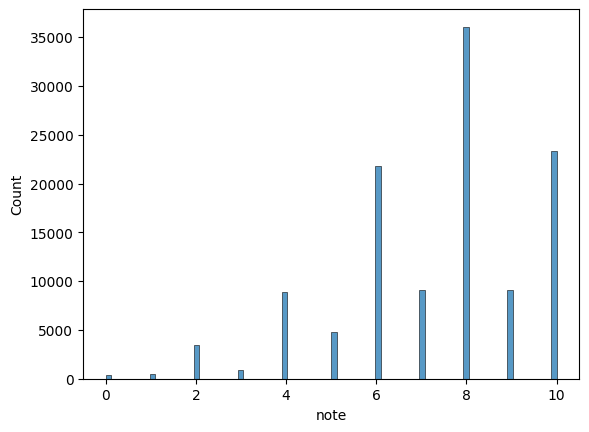

In [16]:
sns.histplot(data=ratings, x = 'note')

- Find/plot the user means rating distribution

<Axes: xlabel='avg_rating', ylabel='Count'>

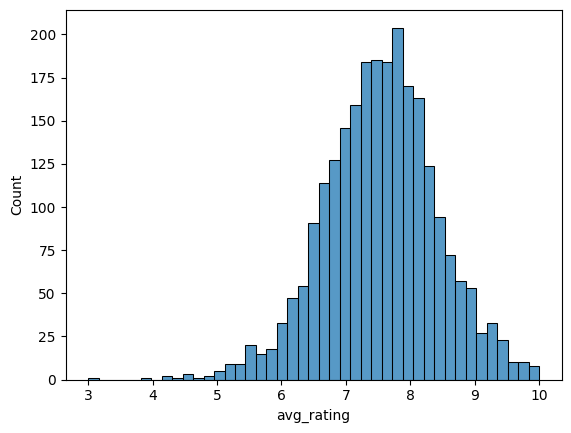

In [17]:
average_ratings = ratings.groupby('author')['note'].mean()
avg_ratings_df = pd.DataFrame({'userId':average_ratings.index, 'avg_rating':average_ratings.values})

sns.histplot(data=avg_ratings_df, x='avg_rating')

- Find/plot the item means rating distribution

<Axes: xlabel='avg_rating', ylabel='Count'>

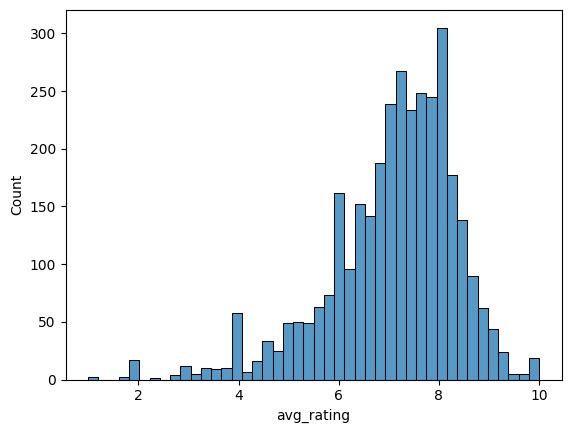

In [18]:
rating_items = ratings.groupby('title')['note'].mean()
avg_rating = pd.DataFrame({'movieId':rating_items.index,'avg_rating':rating_items.values})

sns.histplot(data=avg_rating, x='avg_rating')

## Stats Takeways:

- as it's often the case on rating data, there is a high biais towards good ratings: people tend to rate things they like more than things they dislike

# (Explicit) Collaborative Filtering  by predicting ratings:

The Netflix competition introduced the following predictive framework: the goal is to predict missing ratings using existing ones.

In short, the goal is to define a model $f$ to predict how a user $u$ would rate an item $i$ : 

### $$ f(u,i) = r_{ui} $$

## First, let's build a train/test set

Here, for simplicity, we take the 1 example out of 5 as a test example.

In [19]:
train_indexes,test_indexes = [],[]

for index in range(len(ratings)):
    if index%5 == 0:
        test_indexes.append(index)
    else:
        train_indexes.append(index)

train_ratings = ratings.iloc[train_indexes].copy()
test_ratings = ratings.iloc[test_indexes].copy()

In explicit collaborative filtering, the data are triplets of $(user,item,rating)$

Let's see how one item is.

In [20]:
test_ratings[test_ratings["title"] == 'Mariposas']

,Unnamed: 0,author,title_review,note,title,comment
0,0,Monsieur Guillaume,Voyages sur les ailes des papillons,8,Mariposas,"Lorsque le jeu est jeu, bon, réflexif, joli po..."
5,5,BSI40,Manque un peu de souffle,7,Mariposas,Mariposas est plutôt beau avec un grand platea...
10,10,Max Riock,Vraiment bon,9,Mariposas,NaN
15,15,Lilly,Beau et Doux et Rapide,8,Mariposas,Mariposas est un jeu ou la tension va s'exacer...
20,22,Ricardo31,"Sympa, de bons moments à passer, mais pas un j...",7,Mariposas,J'aime jouer à Mariposas de temps à autre. Qua...
25,30,Emmanuel72,Bon,7,Mariposas,NaN


Given the triplet $(2,131724,5)$, the model goal will be to predict $f(2,131724) = 5$

## Basic Recsys **mean** baselines implementations

First, before digging into more complicated models, we'll implement three really simple baselines:

- The global mean $\mu$
- The user mean $b_u$
- The item mean $b_i$

Indeed, the rating distribution is not uniform at all (it looks more normal). Therefore, the means are good baselines.

## TODO: compute the global training mean, user means and item means

- First, compute basic means to use them as baseline

**NOTE**: User or items can be missing from train-set: be sure to return something in that case

In [21]:
MEAN = train_ratings["note"].mean()
USER_MEANS = train_ratings.groupby("author")["note"].mean()
ITEM_MEANS = train_ratings.groupby("title")["note"].mean()


def mean_rating_pred(user_item):
    user = user_item["author"]
    item = user_item["title"]
    
    return MEAN

def user_mean_rating_pred(user_item):
    user = user_item["author"]
    item = user_item["title"]
    
    return USER_MEANS.get(user, default=MEAN)

def item_mean_rating_pred(user_item):
    user = user_item["author"]
    item = user_item["title"]
    
    return ITEM_MEANS.get(user, default=MEAN)

### You should be able to run the following cell to get mean predictions (instead of None's)

In [22]:
#We create the rating prediction columns
test_ratings["mean_prediction"] = test_ratings[["author","title"]].apply(mean_rating_pred,axis=1)
test_ratings["muser_prediction"] = test_ratings[["author","title"]].apply(user_mean_rating_pred,axis=1) 
test_ratings["mitem_prediction"] = test_ratings[["author","title"]].apply(item_mean_rating_pred,axis=1) 

test_ratings.head(5)

,Unnamed: 0,author,title_review,note,title,comment,mean_prediction,muser_prediction,mitem_prediction
0,0,Monsieur Guillaume,Voyages sur les ailes des papillons,8,Mariposas,"Lorsque le jeu est jeu, bon, réflexif, joli po...",7.341134,8.000000,7.341134
5,5,BSI40,Manque un peu de souffle,7,Mariposas,Mariposas est plutôt beau avec un grand platea...,7.341134,7.203704,7.341134
10,10,Max Riock,Vraiment bon,9,Mariposas,NaN,7.341134,8.507246,7.341134
15,15,Lilly,Beau et Doux et Rapide,8,Mariposas,Mariposas est un jeu ou la tension va s'exacer...,7.341134,8.250000,7.341134
20,22,Ricardo31,"Sympa, de bons moments à passer, mais pas un j...",7,Mariposas,J'aime jouer à Mariposas de temps à autre. Qua...,7.341134,8.285714,7.341134


#### Ok, now that we've got some predictions, let's evaluate them:

## Evaluation metrics:

In explicit collaborative filtering there are three common metrics to compare a ground truth $x$ to a predicted $\hat{x}$:

- Mean Average Error (MAE) : $$\frac{1}{n}\sum^n|(x-\hat{x})|$$
- Mean Squared Error (MSE) : $$\frac{1}{n}\sum^n(x-\hat{x})^2$$
- Rooted Mean Squared Error (RMSE) : $$\sqrt{\frac{1}{n}\sum^n(x-\hat{x})^2}$$

## TODO: Implement those metrics

**Note:** The `predictions` and `truth` variables are arrays of predictions/ground_truth

In [23]:
from math import sqrt

def mae(predictions,truth):
    
    return ((predictions-truth).abs()).mean()

def mse(predictions,truth):
    
    return ((predictions-truth)**2).mean()

def rmse(predictions,truth):
    
    return sqrt(mse(predictions, truth))


def all_metrics(predictions,truth):
    return [f(predictions,truth) for f in [mae,mse,rmse]]

### You should be able to run the following cell to get the metrics results (Instead of None)

In [24]:
metrics = ["mae","mse","rmse"]
results = pd.DataFrame()

results["metrics"] = metrics
results["mean_prediction"] = all_metrics(test_ratings["mean_prediction"],test_ratings["note"])
results["muser_prediction"] = all_metrics(test_ratings["muser_prediction"],test_ratings["note"])
results["mitem_prediction"] = all_metrics(test_ratings["mitem_prediction"],test_ratings["note"])
results = results.set_index("metrics")

print(results)
print("")
print('---Best Models / Metrics: ---')
results.idxmin(1)

         mean_prediction  muser_prediction  mitem_prediction
metrics                                                     
mae             1.703147          1.545615          1.703089
mse             4.390987          3.943571          4.390818
rmse            2.095468          1.985843          2.095428

---Best Models / Metrics: ---


metrics
mae     muser_prediction
mse     muser_prediction
rmse    muser_prediction
dtype: object

# Basic explicit collaborative filtering models - using surprise library

> Surprise is an easy-to-use Python scikit for recommender systems.

> Surprise has a set of built-in algorithms and datasets for you to play with. In its simplest form, it only takes a few lines of code to run a cross-validation procedure:

[More details on the official documentation](https://surprise.readthedocs.io/en/stable/index.html)

In [25]:
## Uncomment this to install required packages if needed (and restart kernel !)
#! pip install --upgrade scikit-surprise

## Loading custom data

We want to be able to load our custom dataset in the framework data structures.  
To do so, we could either load from a raw file or from a dataframe. We do the latter.

(Here is the [Documentation reference](https://surprise.readthedocs.io/en/stable/getting_started.html#use-a-custom-dataset) for loading custom datasets)

In [26]:
from surprise import NormalPredictor, BaselineOnly, SVD
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(train_ratings[['author', 'title', 'note']], Reader(rating_scale=(1, 5)))

## How do models work in Surprise ?

It's fairly easy, Surprise follows the "scikit" way of doing things:
```python
model = GoodModel(params)
model.fit(train_data)
predictions = model.predict(test_data)
```

Ok, let's dig in:

## The baseline model:

>Typical CF data exhibit large user and item effects—systematic tendencies for
some users to give higher ratings than others—and for some items to receive
higher ratings than others. It is customary to adjust the data by accounting for
these effects, which we encapsulate within the baseline estimates. Denote by
μ the overall average rating. A baseline estimate for an unknown rating r ui is
denoted by b ui and accounts for the user and item effects:

## $$ \hat{r}_{ui} = b_{ui} = \mu + b_u + b_i $$

(If user u is unknown, then the bias bu is assumed to be zero. The same applies for item i with bi.)

> The parameters b u and b i indicate the observed deviations of user u and item i,
respectively, from the average. For example, suppose that we want a baseline
estimate for the rating of the movie Titanic by user Joe. Now, say that the
average rating over all movies, μ, is 3.7 stars. Furthermore, Titanic is better
than an average movie, so it tends to be rated 0.5 stars above the average. On
the other hand, Joe is a critical user, who tends to rate 0.3 stars lower than the
average. Thus, the baseline estimate for Titanic’s rating by Joe would be 3.9
stars by calculating 3.7 − 0.3 + 0.5.

(see [Yehuda Koren. Factor in the neighbors: scalable and accurate collaborative filtering. 2010.](http://courses.ischool.berkeley.edu/i290-dm/s11/SECURE/a1-koren.pdf))


## (a) Fit

In [27]:
BaselineModel = BaselineOnly()
BaselineModel.fit(data.build_full_trainset())

Estimating biases using als...


## (b) Predict
If you look at the [Prediction module](https://surprise.readthedocs.io/en/stable/predictions_module.html) documentation,
you'll see that it has a little twist w/ respect to the traditional scikit "predict". It returns a Prediction "[namedTuple](https://docs.python.org/3/library/collections.html#collections.namedtuple)" with the following fields:

- uid – The (raw) user id. (raw means it's the one you supplied, not the one automatically computed by surprise)
- iid – The (raw) item id.
- r_ui (float) – The true rating rui
- est (float) – The estimated rating $r_{ui}$
- details (dict) – Stores additional details about the prediction that might be useful for later analysis.

**=>** if you have a namedTuple `prediction`: `prediction.uid` will contain the user id. 

In [28]:
def opt_bl_rating_pred(user_item):
    user = user_item["author"]
    item = user_item["title"]
    
    prediction = BaselineModel.predict(user,item)
    
    return prediction.est

test_ratings["opt_bl_prediction"] = test_ratings[["author","title"]].apply(opt_bl_rating_pred,axis=1) 

test_ratings

,Unnamed: 0,author,title_review,note,title,comment,mean_prediction,muser_prediction,mitem_prediction,opt_bl_prediction
0,0,Monsieur Guillaume,Voyages sur les ailes des papillons,8,Mariposas,"Lorsque le jeu est jeu, bon, réflexif, joli po...",7.341134,8.000000,7.341134,5.0
5,5,BSI40,Manque un peu de souffle,7,Mariposas,Mariposas est plutôt beau avec un grand platea...,7.341134,7.203704,7.341134,5.0
10,10,Max Riock,Vraiment bon,9,Mariposas,NaN,7.341134,8.507246,7.341134,5.0
15,15,Lilly,Beau et Doux et Rapide,8,Mariposas,Mariposas est un jeu ou la tension va s'exacer...,7.341134,8.250000,7.341134,5.0
20,22,Ricardo31,"Sympa, de bons moments à passer, mais pas un j...",7,Mariposas,J'aime jouer à Mariposas de temps à autre. Qua...,7.341134,8.285714,7.341134,5.0
...,...,...,...,...,...,...,...,...,...,...
118085,176198,YoshiFR,Piou Piou Piou...,6,Mag Blast,"BAh oui il faut faire les bruitages, sinon ça ...",7.341134,6.846154,7.341134,5.0
118090,176203,Pickouette,Piou!!! Boum!!! Badaboum!!! Crac!!! Et re piou!!!,8,Mag Blast,Petit jeu bien fun ou il faut faire des bruita...,7.341134,8.000000,7.341134,5.0
118095,176210,Max59,Merde pas les escadrons!!,6,Mag Blast,"Je n'y ai joué qu'à deux joeurs, mais il se ré...",7.341134,6.000000,7.341134,5.0
118100,176230,Zombie Killer,Un bon jeu tactique,8,Zombie Town,J'ai eu l'occasion de tester ce jeu en deux oc...,7.341134,8.125000,7.341134,5.0


# Your turn !

### __A QUICK NOTE:__ The baseline algorithm is really strong on this dataset, don't worry if the following models performance is worse.

## SVD Algorithm

First, let's try the famous SVD algorithm, as popularized by Simon Funk during the Netflix Prize. 

> Matrix factorization models map both users and items ratings. to a joint latent factor space of dimensionality f, such that user-item interactions are modeled as inner products in that space.

A prediction is made in the following way:

## $$\hat{r}_{ui} = \mu + b_u + b_i + q_i^Tp_u$$

 When baselines are not used, this is equivalent to Probabilistic Matrix Factorization. If user u is unknown, then the bias bu and the factors pu are assumed to be zero. The same applies for item i with bi and qi.

[This is the seminal paper associated to this model](https://datajobs.com/data-science-repo/Recommender-Systems-[Netflix].pdf)
 

## TODO : Try and use the `SVD` surprise model ([related documentation page](https://surprise.readthedocs.io/en/stable/matrix_factorization.html))

In [29]:
SVDmodel = SVD()
SVDmodel.fit(data.build_full_trainset())

## TODO: Use the surprise SVD Implementation to predict missing ratings.

In [30]:
def svd_rating_pred(user_item):
    user = user_item["author"]
    item = user_item["title"]
    
    prediction = SVDmodel.predict(user, item)
    
    return prediction.est

test_ratings["svd_prediction"] = test_ratings[["author","title"]].apply(svd_rating_pred,axis=1) 

## Let's compare every algorithm: the following cell should run and give you the results

In [31]:
metrics = ["mae","mse","rmse"]
results = pd.DataFrame()

results["metrics"] = metrics
results["mean_prediction"] = all_metrics(test_ratings["mean_prediction"],test_ratings["note"])
results["muser_prediction"] = all_metrics(test_ratings["muser_prediction"],test_ratings["note"])
results["mitem_prediction"] = all_metrics(test_ratings["mitem_prediction"],test_ratings["note"])
results["opt_bl_prediction"] = all_metrics(test_ratings["opt_bl_prediction"],test_ratings["note"])
results["svd_prediction"] = all_metrics(test_ratings["svd_prediction"],test_ratings["note"])

results = results.set_index("metrics")

print(results)
print("")
print('---Best Models / Metrics: ---')
results.idxmin(1)

         mean_prediction  muser_prediction  mitem_prediction  \
metrics                                                        
mae             1.703147          1.545615          1.703089   
mse             4.390987          3.943571          4.390818   
rmse            2.095468          1.985843          2.095428   

         opt_bl_prediction  svd_prediction  
metrics                                     
mae               2.748626        2.749256  
mse               9.868396        9.876759  
rmse              3.141400        3.142731  

---Best Models / Metrics: ---


metrics
mae     muser_prediction
mse     muser_prediction
rmse    muser_prediction
dtype: object

## Visualizing learnt embeddings

> Factorizing the user-movie matrix allows us to discover the most descriptive dimensions for predicting movie preferences. We can identify the first few most important dimensions from a matrix decomposition and explore the movies’ location in this new space.

To do so, we propose to use the [Tensorflow projector](https://projector.tensorflow.org/), an accessible easy to use tool online. The following functions/cells walks you through saving both the learnt movie embeddings and labels. 

###  The saving function:

This function saves embeddings (a numpy array) and associated labels into tsv files which can be used by the [Tensorflow projector](https://projector.tensorflow.org/)

In [32]:
def save_embeddings(embs,dict_label,path="saved_word_vectors"):
    """
    embs is Numpy.array(N,size)
    dict_label is {str(word)->int(idx)} or {int(idx)->str(word)}
    """
    def int_first(k,v):
        if type(k) == int:
            return (k,v)
        else:
            return (v,k)

    np.savetxt(f"{path}_vectors.tsv", embs, delimiter="\t")

    #labels 
    if dict_label:
        sorted_labs = np.array([lab for idx,lab in sorted([int_first(k,v) for k,v in dict_label.items()])])
        print(sorted_labs)
        with open(f"{path}_metadata.tsv","w") as metadata_file:
            for x in sorted_labs: #hack for space
                if len(x.strip()) == 0:
                    x = f"space-{len(x)}"
                    
                metadata_file.write(f"{x}\n")

### (a) Loading the movie titles.

We want to label our movie with their titles (indeed, the movieId is not really informative about content)
=> We just read the .csv

In [35]:
titleCSV = pd.read_csv("./BDD/avis.csv")
titleCSV.head(5)

,Unnamed: 0,author,title_review,note,title,comment
0,0,Monsieur Guillaume,Voyages sur les ailes des papillons,8,Mariposas,"Lorsque le jeu est jeu, bon, réflexif, joli po..."
1,1,morlockbob,le festival de Michoacan,7,Mariposas,Comment continuer après un mega hit ? Simpleme...
2,2,SwatSh,Vivez la migration des monarques,7,Mariposas,"Vin d'jeu: Avec Mariposas, Elizabeth Hargrave ..."
3,3,Timi JeuxATheme,Bon,8,Mariposas,NaN
4,4,prunelles,Envolez-moi,9,Mariposas,"Très joli bijou que ce jeu-là ! Le matériel, l..."


### (b) We extract a mapping id => title  

In [38]:
id2title = titleCSV[["Unnamed: 0","title"]].set_index("Unnamed: 0").to_dict()["title"]
list(id2title.items())[:10]

[(0, 'Mariposas'),
 (1, 'Mariposas'),
 (2, 'Mariposas'),
 (3, 'Mariposas'),
 (4, 'Mariposas'),
 (5, 'Mariposas'),
 (6, 'Mariposas'),
 (7, 'Mariposas'),
 (8, 'Mariposas'),
 (9, 'Mariposas')]

### (c) We map the inner surprise id's to the raw id's to the movie title

In [ ]:
full_data = data.build_full_trainset()
index2movie = {x:id2title[full_data.to_raw_iid(x)] for x in full_data.all_items()}
SVDmodel.qi # Holds product vectors
SVDmodel.pu # Holds user vectors

array([[ 0.15726828, -0.01277294, -0.06754165, ...,  0.02398902,
         0.1612741 ,  0.07342197],
       [ 0.02413223,  0.06285161, -0.17121834, ..., -0.00604927,
         0.12868196, -0.03585481],
       [ 0.0817666 , -0.0936749 , -0.01333008, ...,  0.12509804,
        -0.07747281, -0.31368802],
       ...,
       [ 0.1410841 ,  0.21299011, -0.05928253, ...,  0.17996961,
        -0.11796491, -0.13736627],
       [-0.03295298, -0.13889179, -0.19366402, ..., -0.08464033,
        -0.12922983, -0.08526465],
       [ 0.1580264 , -0.02738714, -0.10497621, ..., -0.16588849,
         0.0139639 , -0.00225032]])

### (d) Finally, we save everything

In [ ]:
save_embeddings(SVDmodel.qi,index2movie,path="svd_items")

['Grumpier Old Men (1995)' 'Heat (1995)' 'Seven (a.k.a. Se7en) (1995)' ...
 'Hazard (2005)' 'Blair Witch (2016)' '31 (2016)']


## improving your results with GridSearch :

Every machine learning model is sensible to hyperparameters: Hopefully, surprise provides a way to do parameter search [(related docs)](https://surprise.readthedocs.io/en/stable/model_selection.html#parameter-search). Here's how it work:

In [ ]:
from surprise.model_selection import GridSearchCV


param_grid = {'n_epochs': list(range(2,5)),} #you can add parameters

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3) # you choose the algorithm and the measures
 
gs.fit(data) # You look at best combinations (automatically deals with train/validation splits)


# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best validation RMSE score
print(gs.best_params['rmse'])

# We can now use the algorithm that yields the best rmse:
algo = gs.best_estimator['rmse']
algo.fit(data.build_full_trainset())

0.9110255133849364
{'n_epochs': 4}


#  Finally, try improving your score by testing out all of surprise models and possibilities.

### (TODO)  Use, for example, the KNNs algorithms:

In [ ]:
from surprise.prediction_algorithms.knns import KNNBasic, KNNWithMeans

KNNmodel = KNNBasic()
KNNmodel.fit(data.build_full_trainset())

def knn_rating_pred(user_item):
    user = user_item["userId"]
    item = user_item["movieId"]
    
    prediction = KNNmodel.predict(user,item)
    
    return prediction.est

test_ratings["knn_prediction"] = test_ratings[["userId","movieId"]].apply(knn_rating_pred,axis=1) 

Computing the msd similarity matrix...
Done computing similarity matrix.


In [ ]:
metrics = ["mae","mse","rmse"]
results = pd.DataFrame()

results["metrics"] = metrics
results["mean_prediction"] = all_metrics(test_ratings["mean_prediction"],test_ratings["rating"])
results["muser_prediction"] = all_metrics(test_ratings["muser_prediction"],test_ratings["rating"])
results["mitem_prediction"] = all_metrics(test_ratings["mitem_prediction"],test_ratings["rating"])
results["opt_bl_prediction"] = all_metrics(test_ratings["opt_bl_prediction"],test_ratings["rating"])
results["svd_prediction"] = all_metrics(test_ratings["svd_prediction"],test_ratings["rating"])
results["knn_prediction"] = all_metrics(test_ratings["knn_prediction"],test_ratings["rating"])

results = results.set_index("metrics")

print(results)
print("")
print('---Best Models / Metrics: ---')
results.idxmin(1)

         mean_prediction  muser_prediction  mitem_prediction  \
metrics                                                        
mae             0.820963          0.729720          0.961571   
mse             1.076696          0.879324          1.442640   
rmse            1.037640          0.937723          1.201099   

         opt_bl_prediction  svd_prediction  knn_prediction  
metrics                                                     
mae               0.664942        0.665958        0.716865  
mse               0.748537        0.756146        0.879350  
rmse              0.865180        0.869567        0.937737  

---Best Models / Metrics: ---


metrics
mae     opt_bl_prediction
mse     opt_bl_prediction
rmse    opt_bl_prediction
dtype: object

### Still some time left: [have you tried them all ?](https://surprise.readthedocs.io/en/stable/prediction_algorithms_package.html)